In [1]:

from collections import namedtuple
from collections import namedtuple

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import functional as TF
from matplotlib import pyplot as plt
from PIL import Image
import json
import cv2
import os
import pandas as pd
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import torch
import torch.nn as nn
import os


from PIL import Image, ImageDraw
import json
import matplotlib.pyplot as plt

import cv2

import numpy as np

from tqdm import tqdm



from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [3]:
# Define the paths
test_images_path = '/kaggle/input/cityscapes-segmentation/images/test'
train_images_path = '/kaggle/input/cityscapes-segmentation/images/train'
train_labels_path = '/kaggle/input/cityscapes-segmentation/labels/train'

# List of cities in the dataset
cities = [
    'aachen', 'bochum', 'bremen', 'cologne', 'darmstadt',
    'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena',
    'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart',
    'tubingen', 'ulm', 'weimar', 'zurich'
]

In [4]:
# Extracting updated trainIds from the labels
train_ids = [label.trainId for label in labels]

# Counting unique trainIds
unique_train_ids = set(train_ids)

# Getting the count of unique trainIds
unique_train_id_count = len(unique_train_ids)

print("Unique trainIds after update:", unique_train_ids)
print("Count of unique trainIds after update:", unique_train_id_count)


Unique trainIds after update: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 255}
Count of unique trainIds after update: 21


In [5]:
from PIL import Image
import numpy as np

# Load the image
image_path = '/kaggle/input/cityscapes-segmentation/images/train/aachen/aachen_000000_000019_leftImg8bit.png'
image = Image.open(image_path)

# Convert image to numpy array
image_array = np.array(image)

# Get unique pixel values
unique_pixels = np.unique(image_array)

print("Unique pixel values:", unique_pixels)

Unique pixel values: [  0   1   2   4   5   6   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 2

In [6]:
from PIL import ImageOps
import torch

class EqualizeTransform:
    def __init__(self, p=0.5):
        self.p = p
    
    def __call__(self, img):
        if torch.rand(1) < self.p:
            return ImageOps.equalize(img)
        else:
            return img


In [7]:
from torchvision.transforms import Compose

# Updated Dataset Class

class CityscapesDataset(Dataset):
    def __init__(self, images_path, labels_path, cities, image_transform=None, label_transform=None):
        self.images_path = images_path
        self.labels_path = labels_path
        self.cities = cities
        self.image_transform = image_transform
        self.label_transform = label_transform
        self.image_label_pairs = self._load_images_and_labels()

    def _load_images_and_labels(self):
        image_label_pairs = []
        for city in self.cities:
            city_image_path = os.path.join(self.images_path, city)
            city_label_path = os.path.join(self.labels_path, city)
            image_filenames = [f for f in os.listdir(city_image_path) if f.endswith('_leftImg8bit.png')]

            for filename in image_filenames:
                image_path = os.path.join(city_image_path, filename)
                label_filename = filename.replace('_leftImg8bit.png', '_gtFine_labelTrainIds.png')
                label_path = os.path.join(city_label_path, label_filename)
                image_label_pairs.append((image_path, label_path))
        
        return image_label_pairs

    def __len__(self):
        return len(self.image_label_pairs)

    def __getitem__(self, idx):
        image_path, label_path = self.image_label_pairs[idx]
        
        

        # Open images and labels
        image = Image.open(image_path).convert("RGB")
        label = Image.open(label_path)  # Don't convert label to RGB, it must remain as grayscale (each pixel = class ID)

        # Apply label transformations (only resize, no flips or color conversions)
        if self.label_transform:
            label = self.label_transform(label)

        label_arr = np.array(label)
        label_arr[label_arr > 19] = 20

        # One-hot encoding
        num_classes = 21
        label_one_hot = np.eye(num_classes)[label_arr]
        
        label_one_hot = np.transpose(label_one_hot, (2, 0, 1))
        label = torch.tensor(label_one_hot, dtype=torch.float32)


        # Apply image transformations
        if self.image_transform:
            image = self.image_transform(image)


        return image, label


image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #EqualizeTransform(p=0.5),
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Label Transformation (only resize)
label_transforms = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),  # Use nearest neighbor to avoid changing label values
#     transforms.ToTensor()  # Convert to tensor but without normalizing values
    
])


# Dataset Creation with Correct Transformations
full_dataset = CityscapesDataset(images_path=train_images_path,
                                 labels_path=train_labels_path,
                                 cities=cities,
                                 image_transform=image_transforms,
                                 label_transform=label_transforms)




# Train/Validation Split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# DataLoader for Training and Validation
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)


# Example: Fetch a batch of data
X_batch, y_batch = next(iter(train_loader))
print("X_batch shape:", X_batch.shape)  # Should be [batch_size, 3, 256, 256]
print("y_batch shape:", y_batch.shape)  # Should be [batch_size, 3, 256, 256] (after transformations)

# Convert labels to grayscale after transformations (optional)
# y_batch = y_batch[:, 0, :, :]  # Keep only one channel (grayscale)
print("y_batch shape after converting to grayscale:", y_batch.shape)  # [batch_size, 256, 256]

X_batch shape: torch.Size([2, 3, 256, 256])
y_batch shape: torch.Size([2, 21, 256, 256])
y_batch shape after converting to grayscale: torch.Size([2, 21, 256, 256])


In [8]:
def calculate_label_distribution(dataloader):
    label_counts = torch.zeros(21)  # 21 classes
    
    for _, labels in dataloader:
        # Convert one-hot back to class indices
        label_indices = labels.argmax(dim=1)
        
        # Count occurrences of each label
        for i in range(21):
            label_counts[i] += (label_indices == i).sum().item()
    
    return label_counts

# Calculate distribution
distribution = calculate_label_distribution(train_loader)

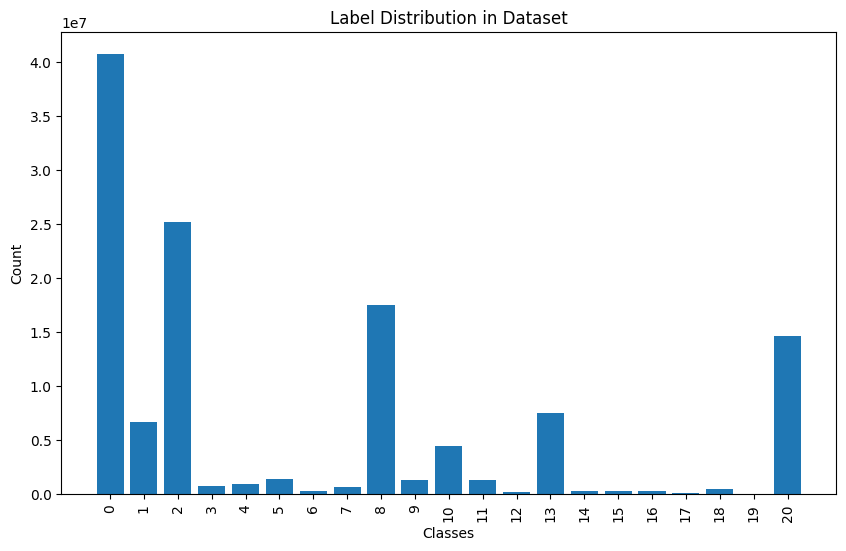

In [9]:
import matplotlib.pyplot as plt

# Convert the distribution to a numpy array
distribution_numpy = distribution.numpy()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(range(21), distribution_numpy, tick_label=[str(i) for i in range(21)])
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Label Distribution in Dataset')
plt.xticks(rotation=90)
plt.show()


In [10]:
#!pip install segmentation-models-pytorch


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import namedtuple

# Define the Label namedtuple structure
Label = namedtuple('Label', ['trainId', 'color'])

# Define the Cityscapes color mapping
labels = [
    Label(trainId=0,  color=(128, 64, 128)),    # road
    Label(trainId=1,  color=(244, 35, 232)),    # sidewalk
    Label(trainId=2,  color=(70, 70, 70)),      # building
    Label(trainId=3,  color=(102, 102, 156)),   # wall
    Label(trainId=4,  color=(190, 153, 153)),   # fence
    Label(trainId=5,  color=(153, 153, 153)),   # pole
    Label(trainId=6,  color=(250, 170, 30)),    # traffic light
    Label(trainId=7,  color=(220, 220, 0)),     # traffic sign
    Label(trainId=8,  color=(107, 142, 35)),    # vegetation
    Label(trainId=9,  color=(152, 251, 152)),   # terrain
    Label(trainId=10, color=(70, 130, 180)),    # sky
    Label(trainId=11, color=(220, 20, 60)),     # person
    Label(trainId=12, color=(255, 0, 0)),       # rider
    Label(trainId=13, color=(0, 0, 142)),       # car
    Label(trainId=14, color=(0, 0, 70)),        # truck
    Label(trainId=15, color=(0, 60, 100)),      # bus
    Label(trainId=16, color=(0, 80, 100)),      # train
    Label(trainId=17, color=(0, 0, 230)),       # motorcycle
    Label(trainId=18, color=(119, 11, 32)),     # bicycle
    Label(trainId=19, color=(0, 0, 0)),         # void
    Label(trainId=20, color=(255, 255, 255)),   # background/other
]

def visualize_results(images, masks, preds, idx=0):
    """
    Visualize the original image, ground truth mask, and predicted mask.
    
    Args:
    - images (torch.Tensor): Batch of input images [batch_size, 3, H, W]
    - masks (torch.Tensor): Batch of ground truth masks [batch_size, num_classes, H, W]
    - preds (torch.Tensor): Batch of predicted masks [batch_size, num_classes, H, W]
    - idx (int): Index of the image in the batch to visualize
    """
    # Unnormalize the image
    mean = torch.tensor([0.485, 0.456, 0.406]).to(images.device)
    std = torch.tensor([0.229, 0.224, 0.225]).to(images.device)
    
    image_np = images[idx].cpu().clone()
    image_np = image_np.permute(1, 2, 0)
    image_np = image_np * std.cpu() + mean.cpu()
    image_np = np.clip(image_np.numpy(), 0, 1)
    
    # Convert masks and predictions to class indices
    mask_np = masks[idx].argmax(dim=0).cpu().numpy()
    pred = torch.argmax(preds[idx], dim=0).cpu().numpy()
    
    # Create the color palette
    palette = [(0, 0, 0)] * 256  # Initialize with black for all entries
    
    # Fill in the palette with the defined colors
    for label in labels:
        if label.trainId < 255:
            palette[label.trainId] = tuple(x/255.0 for x in label.color)  # Normalize to [0,1]
    
    # Convert palette to numpy array
    palette_np = np.array(palette)
    
    # Map indices to colors
    mask_color = palette_np[mask_np]
    pred_color = palette_np[pred]
    
    # Create the visualization
    plt.figure(figsize=(15, 5))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title(f"Original Image {idx + 1}")
    plt.axis('off')
    
    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask_color)
    plt.title("Ground Truth Mask")
    plt.axis('off')
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_color)
    plt.title("Predicted Mask")
    plt.axis('off')
    
    # Add a color legend
    legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=tuple(x/255.0 for x in label.color), label=f'Class {label.trainId}')
                      for label in labels]
    plt.figlegend(handles=legend_elements, 
                 loc='center right', 
                 bbox_to_anchor=(1.2, 0.5),
                 title='Classes')
    
    plt.tight_layout()
    plt.show()

# Example usage:
"""
# Load your data
train_loader = DataLoader(...)
images, masks = next(iter(train_loader))

# Get model predictions
model.eval()
with torch.no_grad():
    predictions = model(images)

# Visualize results
visualize_results(images, masks, predictions, idx=0)
"""

'\n# Load your data\ntrain_loader = DataLoader(...)\nimages, masks = next(iter(train_loader))\n\n# Get model predictions\nmodel.eval()\nwith torch.no_grad():\n    predictions = model(images)\n\n# Visualize results\nvisualize_results(images, masks, predictions, idx=0)\n'

# ***DEEPLAB V3***

In [12]:
# !pip install torchvision segmentation-models-pytorch
# !pip install segmentation-models-pytorch --upgrade

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
#from segmentation_models_pytorch import DeepLabV3Plus


def calculate_iou(pred, target, num_classes):
    """Calculate Intersection over Union (IoU) for multi-class predictions."""
    #print(f"IoU calculation - Pred shape: {pred.shape}, Target shape: {target.shape}")
    
    pred = torch.argmax(pred, dim=1)
    if len(target.shape) == 4:
        target = torch.argmax(target, dim=1)
    
    #print(f"After conversion - Pred shape: {pred.shape}, Target shape: {target.shape}")
    
    iou_scores = []
    for cls in range(num_classes):
        pred_mask = (pred == cls)
        target_mask = (target == cls)
        
        intersection = (pred_mask & target_mask).sum().float()
        union = (pred_mask | target_mask).sum().float()
        
        if union == 0:
            iou_scores.append(float('nan'))
        else:
            iou_scores.append((intersection / union).item())
    
    valid_ious = [iou for iou in iou_scores if not torch.isnan(torch.tensor(iou))]
    return sum(valid_ious) / len(valid_ious) if valid_ious else 0.0

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        #print(f"Dice Loss calculation - Pred shape: {pred.shape}, Target shape: {target.shape}")
        
        if len(target.shape) == 3:
            target = torch.nn.functional.one_hot(target.long(), num_classes=pred.shape[1])
            target = target.permute(0, 3, 1, 2)
        
        #print(f"After format adjustment - Pred shape: {pred.shape}, Target shape: {target.shape}")
        
        numerator = 2 * (pred * target).sum(dim=(2, 3))
        denominator = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice_score = (numerator + self.smooth) / (denominator + self.smooth)
        return 1 - dice_score.mean(), dice_score.mean().item()


# def train_model(model, train_loader, val_loader, num_epochs, device, visualization_interval=50):
#     model = model.to(device)
#     criterion = DiceLoss()
#     optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
#     for epoch in range(num_epochs):
#         model.train()
#         epoch_loss = 0
#         epoch_iou = 0
#         epoch_dice = 0
#         batch_count = 0
        
#         for batch_idx, (images, masks) in enumerate(train_loader):
#             #print(f"\nBatch {batch_idx + 1}")
#            # print(f"Input images shape: {images.shape}")
#             #print(f"Input masks shape: {masks.shape}")
            
#             images = images.to(device)
#             masks = masks.to(device)
            
#             optimizer.zero_grad()
            
#             outputs = model(images)
#             #print(f"Model output shape: {outputs.shape}")
            
#             loss, dice_score = criterion(outputs, masks)
#             loss.backward()
#             optimizer.step()
            
#             batch_iou = calculate_iou(outputs.detach(), masks, num_classes=21)
            
#             epoch_loss += loss.item()
#             epoch_iou += batch_iou
#             epoch_dice += dice_score
#             batch_count += 1
            
#             if batch_idx % visualization_interval == 0:
#                 print(f"\nEpoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}]")
#                 print(f"Loss: {loss.item():.4f}, IoU: {batch_iou:.4f}, Dice Score: {dice_score:.4f}")
#                 visualize_results(images, masks, outputs.detach())
        
#         # Epoch summary
#         avg_loss = epoch_loss / batch_count
#         avg_iou = epoch_iou / batch_count
#         avg_dice = epoch_dice / batch_count
#         print(f"\nEpoch [{epoch+1}/{num_epochs}] Summary:")
#         print(f"Average Loss: {avg_loss:.4f}")
#         print(f"Average IoU: {avg_iou:.4f}")
#         print(f"Average Dice Score: {avg_dice:.4f}")
        
#         # Validation
#         model.eval()
#         val_loss = 0
#         val_iou = 0
#         val_dice = 0
#         val_batch_count = 0
        
#         with torch.no_grad():
#             for val_idx, (val_images, val_masks) in enumerate(val_loader):
#                 val_images = val_images.to(device)
#                 val_masks = val_masks.to(device)
                
#                 val_outputs = model(val_images)
#                 val_batch_loss, val_dice_score = criterion(val_outputs, val_masks)
#                 val_batch_iou = calculate_iou(val_outputs, val_masks, num_classes=21)
                
#                 val_loss += val_batch_loss.item()
#                 val_iou += val_batch_iou
#                 val_dice += val_dice_score
#                 val_batch_count += 1
                
#                 # Visualize first validation batch
#                 if val_idx == 0:
#                     print("\nValidation Visualization:")
#                     visualize_results(val_images, val_masks, val_outputs)
        
#         avg_val_loss = val_loss / val_batch_count
#         avg_val_iou = val_iou / val_batch_count
#         avg_val_dice = val_dice / val_batch_count
#         print(f"Validation Loss: {avg_val_loss:.4f}")
#         print(f"Validation IoU: {avg_val_iou:.4f}")
#         print(f"Validation Dice Score: {avg_val_dice:.4f}")

# # Usage example
# if __name__ == "__main__":
#     model = DeepLabV3Plus(
#         encoder_name="resnet50",
#         encoder_weights="imagenet",
#         in_channels=3,
#         classes=21
#     )
    
#     num_epochs = 50
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     train_model(model, train_loader, val_loader, num_epochs, device)

# ***UNET***

In [14]:
class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Decoder
        self.dec4 = self.upconv(512, 256)
        self.dec3 = self.upconv(256, 128)
        self.dec2 = self.upconv(128, 64)
        self.dec1 = self.upconv(64, n_classes)  # Output should match number of classes

        # Max-pooling and Upsampling
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True)
        )

    def upconv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Decoder
        d4 = self.upsample(self.dec4(e4))
        d3 = self.upsample(self.dec3(d4 + e3))  # Skip connection
        d2 = self.upsample(self.dec2(d3 + e2))  # Skip connection
        d1 = self.dec1(d2 + e1)  # Skip connection

        return d1  # Output segmentation map

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch [10/40] Training Summary:
Average Cross Entropy Loss: 0.4397
Average Dice Loss: 0.6776
Average Dice Score: 0.3224
Average IoU Score: 0.4126

Epoch [10/40] Validation Summary:
Average Cross Entropy Loss: 0.4551
Average Dice Loss: 0.6896
Average Dice Score: 0.3104
Average IoU Score: 0.3941


Epoch [20/40] Training Summary:
Average Cross Entropy Loss: 0.2948
Average Dice Loss: 0.6178
Average Dice Score: 0.3822
Average IoU Score: 0.4895

Epoch [20/40] Validation Summary:
Average Cross Entropy Loss: 0.4208
Average Dice Loss: 0.6558
Average Dice Score: 0.3442
Average IoU Score: 0.4318


Epoch [30/40] Training Summary:
Average Cross Entropy Loss: 0.1891
Average Dice Loss: 0.5635
Average Dice Score: 0.4365
Average IoU Score: 0.5824

Epoch [30/40] Validation Summary:
Average Cross Entropy Loss: 0.4842
Average Dice Loss: 0.6472
Average Dice Score: 0.3528
Average IoU Score: 0.4356


Epoch [40/40] Training Summary:
Average Cross Entropy Loss: 0.1308
Average Dice Loss: 0.5255
Average Dice Sc

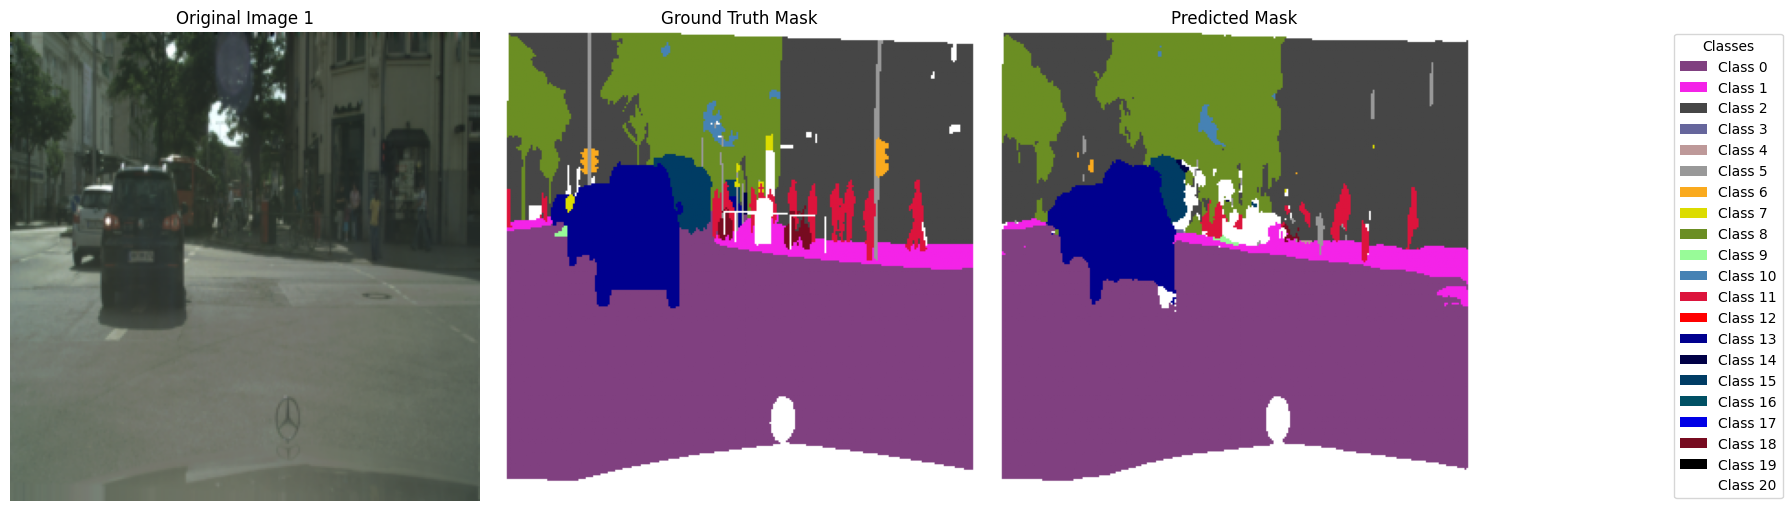

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

def train_model(model, train_loader, val_loader, num_epochs, device, visualization_interval=50):
    model = model.to(device)
    # Use a combination of losses for better Dice score
    ce_criterion = nn.CrossEntropyLoss()
    dice_criterion = DiceLoss()
    
    # Add learning rate scheduler for better convergence
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', 
                                                   factor=0.5, patience=5,
                                                   verbose=True)
    
    # Keep track of best model
    best_dice = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        epoch_ce_loss = 0
        epoch_dice_loss = 0
        epoch_iou = 0
        epoch_dice_score = 0
        batch_count = 0
        
        for batch_idx, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            if len(masks.shape) == 4:
                target_indices = masks.argmax(dim=1)
            else:
                target_indices = masks
            
            # Combine CrossEntropy and Dice loss for better segmentation
            ce_loss = ce_criterion(outputs, target_indices)
            dice_loss, dice_score = dice_criterion(outputs.softmax(dim=1), masks)
            combined_loss = ce_loss + dice_loss  # Give equal weight to both losses
            
            combined_loss.backward()
            
            # Add gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            with torch.no_grad():
                batch_iou = calculate_iou(outputs.detach(), masks, num_classes=21)
            
            epoch_ce_loss += ce_loss.item()
            epoch_dice_loss += dice_loss
            epoch_iou += batch_iou
            epoch_dice_score += dice_score
            batch_count += 1
        
        # Print training summary every 10 epochs
        if (epoch + 1) % 10 == 0:
            avg_ce_loss = epoch_ce_loss / batch_count
            avg_dice_loss = epoch_dice_loss / batch_count
            avg_iou = epoch_iou / batch_count
            avg_dice_score = epoch_dice_score / batch_count
            
            print("\n" + "="*50)
            print(f"Epoch [{epoch+1}/{num_epochs}] Training Summary:")
            print(f"Average Cross Entropy Loss: {avg_ce_loss:.4f}")
            print(f"Average Dice Loss: {avg_dice_loss:.4f}")
            print(f"Average Dice Score: {avg_dice_score:.4f}")
            print(f"Average IoU Score: {avg_iou:.4f}")
            print("="*50)
        
        # Validation Phase
        model.eval()
        val_ce_loss = 0
        val_dice_loss = 0
        val_iou = 0
        val_dice_score = 0
        val_batch_count = 0
        
        # Save first batch for final visualization
        final_val_images = None
        final_val_masks = None
        final_val_outputs = None
        
        with torch.no_grad():
            for val_idx, (val_images, val_masks) in enumerate(val_loader):
                if val_idx == 0:
                    final_val_images = val_images
                    final_val_masks = val_masks
                
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)
                
                val_outputs = model(val_images)
                
                if val_idx == 0:
                    final_val_outputs = val_outputs.cpu()
                
                if len(val_masks.shape) == 4:
                    val_target_indices = val_masks.argmax(dim=1)
                else:
                    val_target_indices = val_masks
                
                val_ce_loss_batch = ce_criterion(val_outputs, val_target_indices)
                val_dice_loss_batch, val_dice_score_batch = dice_criterion(
                    val_outputs.softmax(dim=1), val_masks)
                val_batch_iou = calculate_iou(val_outputs, val_masks, num_classes=21)
                
                val_ce_loss += val_ce_loss_batch.item()
                val_dice_loss += val_dice_loss_batch
                val_iou += val_batch_iou
                val_dice_score += val_dice_score_batch
                val_batch_count += 1
        
        # Calculate validation metrics
        avg_val_dice_score = val_dice_score / val_batch_count
        
        # Update learning rate based on validation Dice score
        scheduler.step(avg_val_dice_score)
        
        # Save best model
        if avg_val_dice_score > best_dice:
            best_dice = avg_val_dice_score
            best_model_state = model.state_dict().copy()
        
        # Print validation summary every 10 epochs
        if (epoch + 1) % 10 == 0:
            avg_val_ce_loss = val_ce_loss / val_batch_count
            avg_val_dice_loss = val_dice_loss / val_batch_count
            avg_val_iou = val_iou / val_batch_count
            
            print("\n" + "="*50)
            print(f"Epoch [{epoch+1}/{num_epochs}] Validation Summary:")
            print(f"Average Cross Entropy Loss: {avg_val_ce_loss:.4f}")
            print(f"Average Dice Loss: {avg_val_dice_loss:.4f}")
            print(f"Average Dice Score: {avg_val_dice_score:.4f}")
            print(f"Average IoU Score: {avg_val_iou:.4f}")
            print("="*50 + "\n")
    
    # Load best model before final visualization
    model.load_state_dict(best_model_state)
    
    # Final visualization
    print("\nFinal Results Visualization:")
    rand_idx = random.randint(0, final_val_images.size(0) - 1)
    print(f"Showing random sample {rand_idx} from validation set")
    print(f"Best Validation Dice Score: {best_dice:.4f}")
    visualize_results(final_val_images, final_val_masks, final_val_outputs, idx=rand_idx)

# Example usage
if __name__ == "__main__":
    model = UNet(n_classes=21)
    num_epochs = 40
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_model(model, train_loader, val_loader, num_epochs, device)